In [1]:
import math
import numpy as np
import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe

from helper_fn import * 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pandemic_SIR_model(N = 1000, alpha = 10.9, beta = 1.0, Ts = 0.001):
    # E.g. https://www.nature.com/articles/s41598-020-72529-y

    susceptible = dy.signal()
    infected = dy.signal()
    recovered = dy.signal()
    
    infection_rate = alpha/N * susceptible*infected
    recover_rate = beta*infected

    susceptible << dy.euler_integrator( 0-alpha/N * susceptible*infected, Ts, N )
    infected    << dy.euler_integrator( infection_rate - recover_rate, Ts, initial_state=10  )
    recovered   << dy.euler_integrator( recover_rate, Ts )
    
    return susceptible, infected, recovered, infection_rate

In [3]:
system = dy.enter_system()

# the diagram
susceptible, infected, recovered, infection_rate = pandemic_SIR_model(N = 1000, alpha = 7.0, beta = 1.0, Ts = 0.001)

# define output(s)
dy.append_primay_ouput(susceptible, 'susceptible')
dy.append_primay_ouput(infected, 'infected')
dy.append_primay_ouput(recovered, 'recovered')

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.WasmRuntime(), folder="generated/pandemic_control", build=False)

#
dy.clear()

compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/pandemic_control .


In [4]:
compiled_system = dyexe.CompiledCode(code_gen_results)
sim_results = dyexe.run_batch_simulation(dyexe.SystemInstance(compiled_system), input_data={}, N=5000)

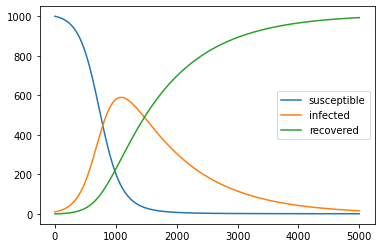

In [5]:
plt.figure()
plt.plot( sim_results['susceptible'] )
plt.plot( sim_results['infected'] )
plt.plot( sim_results['recovered']  )
plt.legend(['susceptible', 'infected', 'recovered'])
plt.show()

In [6]:
system = dy.enter_system()

# the diagram


alpha_0 = 7
aplha_lockdown = 0.3


def control(susceptible, infected, recovered, infection_rate):
    

    with dy.sub_statemachine( "statemachine1" ) as switch:

        with switch.new_subsystem('no_measures') as system:

            alpha_controlled = dy.float64(alpha_0)

            
            #go_into_lockdown = infected > 100
            go_into_lockdown = infection_rate > 50
            
            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=go_into_lockdown, new_value=1 )

            system.set_switched_outputs([ alpha_controlled ], next_state)


        with switch.new_subsystem('lockdown') as system:

            alpha_controlled = dy.float64(aplha_lockdown)

            # release_lockdown = infected < 40
            release_lockdown = infection_rate < 35

                        
            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=release_lockdown, new_value=0 )

            system.set_switched_outputs([ alpha_controlled ], next_state)

        
    alpha_controlled = switch.outputs[0]
    
    
    return alpha_controlled


# feedback signals
susceptible = dy.signal()
infected = dy.signal()
recovered = dy.signal()
infection_rate = dy.signal()
measured_infection_rate = dy.signal()

#
alpha_controlled = control(susceptible, infected, recovered, infection_rate=measured_infection_rate)

#
alpha_controlled = dy.delay(alpha_controlled, initial_state=alpha_0)

#
_susceptible, _infected, _recovered, _infection_rate = pandemic_SIR_model(N = 1000, alpha = alpha_controlled, beta = 1.0, Ts = 0.001)
susceptible << _susceptible
infected << _infected
recovered << _recovered
infection_rate << _infection_rate

measured_infection_rate << dy.dtf_lowpass_1_order( infection_rate, 0.999 )

# define output(s)
dy.append_primay_ouput(alpha_controlled, 'alpha_controlled')

dy.append_primay_ouput(susceptible, 'susceptible')
dy.append_primay_ouput(infected, 'infected')
dy.append_primay_ouput(recovered, 'recovered')
dy.append_primay_ouput(infection_rate, 'infection_rate')

dy.append_primay_ouput(measured_infection_rate, 'measured_infection_rate')


# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.WasmRuntime(), folder="generated/pandemic_control", build=False)

#
dy.clear()

compiling system Subsystem1000_no_measures (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system Subsystem1001_lockdown (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/pandemic_control .


In [7]:
compiled_system = dyexe.CompiledCode(code_gen_results)
sim_results = dyexe.run_batch_simulation(dyexe.SystemInstance(compiled_system), input_data={}, N=5000)

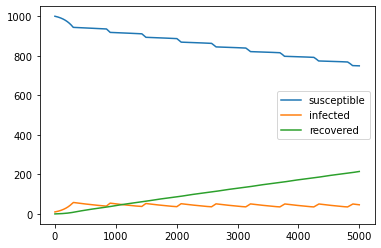

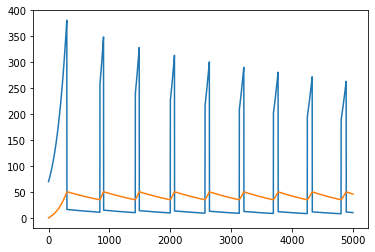

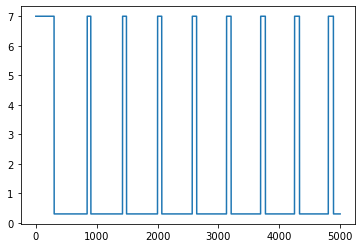

In [8]:
plt.figure()
plt.plot( sim_results['susceptible'] )
plt.plot( sim_results['infected'] )
plt.plot( sim_results['recovered']  )
plt.legend(['susceptible', 'infected', 'recovered'])
plt.show()

plt.figure()
plt.plot( sim_results['infection_rate'] )
plt.plot( sim_results['measured_infection_rate'] )
plt.show()

plt.figure()
plt.plot( sim_results['alpha_controlled'] )
plt.show()


In [9]:
def pandemic_SEIR_model(N = 1000, beta = 1.0, sigma = 1.0, gamma = 1.0, Ts = 0.001):
    # https://julia.quantecon.org/continuous_time/seir_model.html
    
    susceptible = dy.signal()
    exposed = dy.signal()
    infected = dy.signal()
    recovered = dy.signal()
    
    infection_rate = sigma*exposed
    recovery_rate = gamma*infected

    susceptible << dy.euler_integrator( 0 - beta/N * infected*susceptible, Ts, N )
    exposed     << dy.euler_integrator( beta/N * infected*susceptible  - infection_rate,  Ts, 0 )
    infected    << dy.euler_integrator( infection_rate - recovery_rate, Ts, initial_state=10  )
    recovered   << dy.euler_integrator( recovery_rate, Ts )
    
    
    return susceptible, exposed, infected, recovered, infection_rate, recovery_rate


In [10]:
system = dy.enter_system()

# the diagram
susceptible, exposed, infected, recovered, infection_rate, recovery_rate = pandemic_SEIR_model(N = 1000, beta = 8.0, sigma = 2.0, gamma = 1.0, Ts = 0.001)

# define output(s)
dy.append_primay_ouput(susceptible, 'susceptible')
dy.append_primay_ouput(exposed,     'exposed')
dy.append_primay_ouput(infected,    'infected')
dy.append_primay_ouput(recovered,   'recovered')

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.WasmRuntime(), folder="generated/pandemic_control", build=False)

#
dy.clear()

compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/pandemic_control .


In [11]:
compiled_system = dyexe.CompiledCode(code_gen_results)
sim_results = dyexe.run_batch_simulation(dyexe.SystemInstance(compiled_system), input_data={}, N=5000)

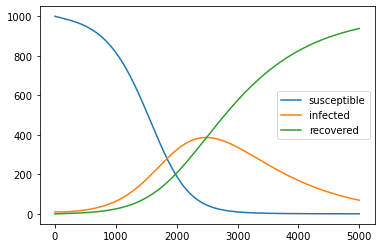

In [12]:
plt.figure()
plt.plot( sim_results['susceptible'] )
plt.plot( sim_results['infected'] )
plt.plot( sim_results['recovered']  )
plt.legend(['susceptible', 'infected', 'recovered'])
plt.show()

In [16]:
system = dy.enter_system()

# the diagram


beta_0 = 5
beta_lockdown = 1


def control(susceptible, infected, recovered, infection_rate):
    
    with dy.sub_statemachine( "statemachine1" ) as switch:
        with switch.new_subsystem('no_measures') as system:

            beta_controlled = dy.float64(beta_0)
            
            go_into_lockdown = infection_rate > 200
            
            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=go_into_lockdown, new_value=1 )
            system.set_switched_outputs([ beta_controlled ], next_state)


        with switch.new_subsystem('lockdown') as system:

            beta_controlled = dy.float64(beta_lockdown)

            release_lockdown = infection_rate < 100
                        
            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=release_lockdown, new_value=0 )
            system.set_switched_outputs([ beta_controlled ], next_state)

        
    beta_controlled = switch.outputs[0]
    
    
    return beta_controlled


# feedback signals
susceptible = dy.signal()
infected = dy.signal()
recovered = dy.signal()
infection_rate = dy.signal()
measured_infection_rate = dy.signal()

#
beta_controlled = control(susceptible, infected, recovered, infection_rate=measured_infection_rate)

#
beta_controlled = dy.delay(beta_controlled, initial_state=alpha_0)

#
_susceptible, _exposed, _infected, _recovered, _infection_rate, _recovery_rate = pandemic_SEIR_model(N = 1000, beta = beta_controlled, sigma = 2.0, gamma = 1.0, Ts = 0.001)

susceptible << _susceptible
infected << _infected
recovered << _recovered
infection_rate << _infection_rate

#measured_infection_rate << dy.dtf_lowpass_1_order( infection_rate, 0.999 )
measured_infection_rate << dy.delay( infection_rate)

# define output(s)
dy.append_primay_ouput(beta_controlled, 'beta_controlled')
dy.append_primay_ouput(susceptible, 'susceptible')
dy.append_primay_ouput(infected, 'infected')
dy.append_primay_ouput(recovered, 'recovered')
dy.append_primay_ouput(infection_rate, 'infection_rate')
dy.append_primay_ouput(measured_infection_rate, 'measured_infection_rate')

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.WasmRuntime(), folder="generated/pandemic_control", build=False)

#
dy.clear()

compiling system Subsystem1000_no_measures (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system Subsystem1001_lockdown (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/pandemic_control .


In [17]:
compiled_system = dyexe.CompiledCode(code_gen_results)
sim_results = dyexe.run_batch_simulation(dyexe.SystemInstance(compiled_system), input_data={}, N=5000)

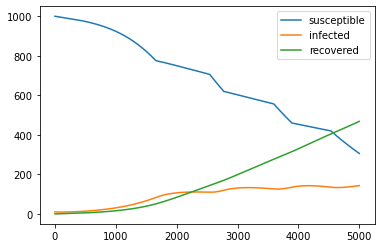

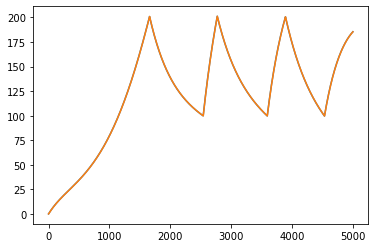

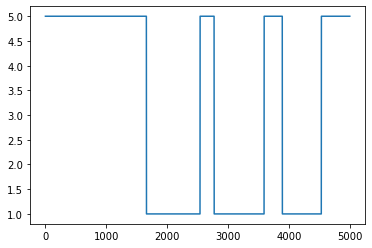

In [18]:
plt.figure()
plt.plot( sim_results['susceptible'] )
plt.plot( sim_results['infected'] )
plt.plot( sim_results['recovered']  )
plt.legend(['susceptible', 'infected', 'recovered'])
plt.show()

plt.figure()
plt.plot( sim_results['infection_rate'] )
plt.plot( sim_results['measured_infection_rate'] )
plt.show()

plt.figure()
plt.plot( sim_results['beta_controlled'] )
plt.show()
